In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import cv2
from keras import layers, models
from keras import applications
from keras import callbacks
from pycocotools import mask as maskUtils
from keras import backend

In [2]:
class ImageSegmentationModel:
    def __init__(self, input_shape=(256, 256, 3), num_classes=11):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = layers.Input(shape=self.input_shape)
        base_model = applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
        base_model.trainable = True

        for layer in base_model.layers[:20]:
            layer.trainable = False

        conv1 = base_model.get_layer('block2a_expand_activation').output
        conv2 = base_model.get_layer('block3a_expand_activation').output
        conv3 = base_model.get_layer('block4a_expand_activation').output
        conv4 = base_model.get_layer('block6a_expand_activation').output
        conv5 = base_model.get_layer('top_activation').output

        up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
        up6 = layers.concatenate([up6, conv4], axis=3)
        conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
        conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

        up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
        up7 = layers.concatenate([up7, conv3], axis=3)
        conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
        conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

        up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
        up8 = layers.concatenate([up8, conv2], axis=3)
        conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
        conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

        up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
        up9 = layers.concatenate([up9, conv1], axis=3)
        conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
        conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

        up10 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv9)
        conv10 = layers.Conv2D(32, 3, activation='relu', padding='same')(up10)
        conv10 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv10)

        outputs = layers.Conv2D(self.num_classes, 1, activation='softmax')(conv10)

        model = models.Model(inputs=[inputs], outputs=[outputs])

        return model
    
    def preprocess_data(self, annotation):
        size = annotation['size']
        mask_encoded = annotation['counts']
        mask_encoded = np.array2string(annotation['counts'].numpy())
        mask_encoded = mask_encoded[3:-2]
        rle = {'size': size, 'counts': mask_encoded.replace('\\\\','\\')}
        mask = maskUtils.decode(rle)
        return mask
    
    def load_dataset(self, dataset_name='test_coco_dataset', split='train'):
        return tfds.load(dataset_name, split=split)
    
    def prepare_data(self, dataset):
        images = []
        image_id_to_index = {}
        image_id_to_mask = {}
        masks = []

        for idx, example in enumerate(dataset):
            img_id = example['image_id'].numpy()
            image = example['image'].numpy()
            image = cv2.resize(image, (256, 256))
            images.append(image)
            image_id_to_index[img_id] = idx

        images = np.array(images)
        masks = np.zeros((len(images), 256, 256), dtype=np.uint8)

        for example in dataset:
            img_id = example['image_id'].numpy()
            segmentation = example['segmentation']
            object_class = example['label'].numpy()
            mask = self.preprocess_data(segmentation)
            mask = cv2.resize(mask, (256, 256))
            mask[mask == 1] = object_class

            if img_id in image_id_to_mask:
                existing_mask = image_id_to_mask[img_id]
                combined_mask = np.maximum(existing_mask, mask)
                image_id_to_mask[img_id] = combined_mask
            else:
                image_id_to_mask[img_id] = mask

        masks = [image_id_to_mask[example['image_id'].numpy()] for example in dataset]

        masks = np.array(masks).astype(np.float32)
        images = images / 255.0

        # Convert masks to categorical
        # masks = tf.keras.utils.to_categorical(masks, num_classes=self.num_classes)
        print(masks)
        return images, masks

    @staticmethod
    def dice_loss(y_true, y_pred, smooth=1.):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
        return 1. - score

    def dice_coefficient(self, y_true, y_pred):
        smooth=1.
        y_true_f = tf.keras.backend.flatten(tf.keras.backend.one_hot(tf.keras.backend.cast(y_true, 'int32'), num_classes=self.num_classes))
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    def data_generator(self, images, masks, batch_size):
        while True:
            for start in range(0, len(images), batch_size):
                end = min(start + batch_size, len(images))
                batch_images = images[start:end]
                batch_masks = masks[start:end]
                
                batch_images = np.array(batch_images)
                batch_masks = np.array(batch_masks)
                
                yield batch_images, batch_masks

    def train(self, train_images, train_masks, val_images, val_masks, epochs=75, batch_size=16):
        model = self.model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy', self.dice_coefficient])
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_model_multiclass.keras', save_best_only=True, monitor='val_loss')

        train_gen = self.data_generator(train_images, train_masks, batch_size)
        val_gen = self.data_generator(val_images, val_masks, batch_size)

        num_train_images = len(train_images) if isinstance(train_images, list) else train_images.shape[0]
        num_val_images = len(val_images) if isinstance(val_images, list) else val_images.shape[0]

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            steps_per_epoch=num_train_images // batch_size,
            validation_steps=num_val_images // batch_size,
            callbacks=[early_stopping, model_checkpoint]
        )

        return history

    def plot_training(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    def predict(self, image):
        image = cv2.resize(image, (256, 256))
        image = np.expand_dims(image, axis=0) / 255.0
        prediction = self.model.predict(image)
        prediction_mask = np.argmax(prediction, axis=-1)  # Преобразование вероятностей в классы
        prediction_mask = np.squeeze(prediction_mask)
        return prediction_mask


    def visualize_prediction(self, image, prediction):
        prediction = np.argmax(prediction, axis=-1)
        plt.figure(figsize=(10, 10))

        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(image)

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(prediction, cmap='jet', alpha=0.5)

        plt.show()

In [3]:
# Использование класса
print('penis')
segmentation_model = ImageSegmentationModel()
dataset = segmentation_model.load_dataset()

train_images, train_masks = segmentation_model.prepare_data(dataset)
train_images, train_masks = train_images[:2000], train_masks[:2000]

val_images, val_masks = segmentation_model.prepare_data(dataset)
val_images, val_masks = val_images[4000:], val_masks[4000:]



pred_images = train_images[-5:]

print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)
print("Validation images shape:", val_images.shape)
print("Validation masks shape:", val_masks.shape)


penis
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [3. 3. 3. ... 0. 0. 0.]
  [3. 3. 3. ... 0. 0. 0.]
  [3. 3. 3. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [5. 5. 5. ... 0. 0. 0.]
  [5. 5. 5. ... 0. 0. 0.]
  [5. 5. 5. ... 0. 0. 0.]]

 [[8. 8. 8. ... 0. 0. 0.]
  [8. 8. 8. ... 0. 0. 0.]
  [8. 8. 8. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 4. 4. 0.]
  [0. 0. 0. ... 4. 4. 4.]
  [0. 0. 0. ... 4. 4. 4.]
  ...
  [3. 3. 3. ... 9. 9. 9.]
  [3. 3. 3. ... 9. 9. 9.]
  [3. 3. 3. ... 9. 9. 9.]]

 [[9. 9. 9. ... 2. 2. 2.]
  [9. 9. 9. ... 2. 2. 2.]
  [9. 9. 9. ... 2. 2. 2.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0

Epoch 1/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 770s 6s/step - accuracy: 0.3580 - dice_coefficient: 0.1410 - loss: 2.1025 - val_accuracy: 0.6602 - val_dice_coefficient: 0.3250 - val_loss: 1.6189
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 710s 6s/step - accuracy: 0.6621 - dice_coefficient: 0.4399 - loss: 1.4366 - val_accuracy: 0.6597 - val_dice_coefficient: 0.5966 - val_loss: 5.4190
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 717s 6s/step - accuracy: 0.6621 - dice_coefficient: 0.5402 - loss: 1.1982 - val_accuracy: 0.6607 - val_dice_coefficient: 0.5661 - val_loss: 3.6992
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 717s 6s/step - accuracy: 0.6632 - dice_coefficient: 0.5739 - loss: 1.1073 - val_accuracy: 0.5552 - val_dice_coefficient: 0.2193 - val_loss: 2.1021
Epoch 5/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 716s 6s/step - accuracy: 0.6711 - dice_coefficient: 0.5925 - loss: 1.0571 - val_accuracy: 0.4142 - val_dice_coefficient: 0.1654 - val_loss: 1.9854
Epoch 6/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 714s 6s/step - accuracy: 

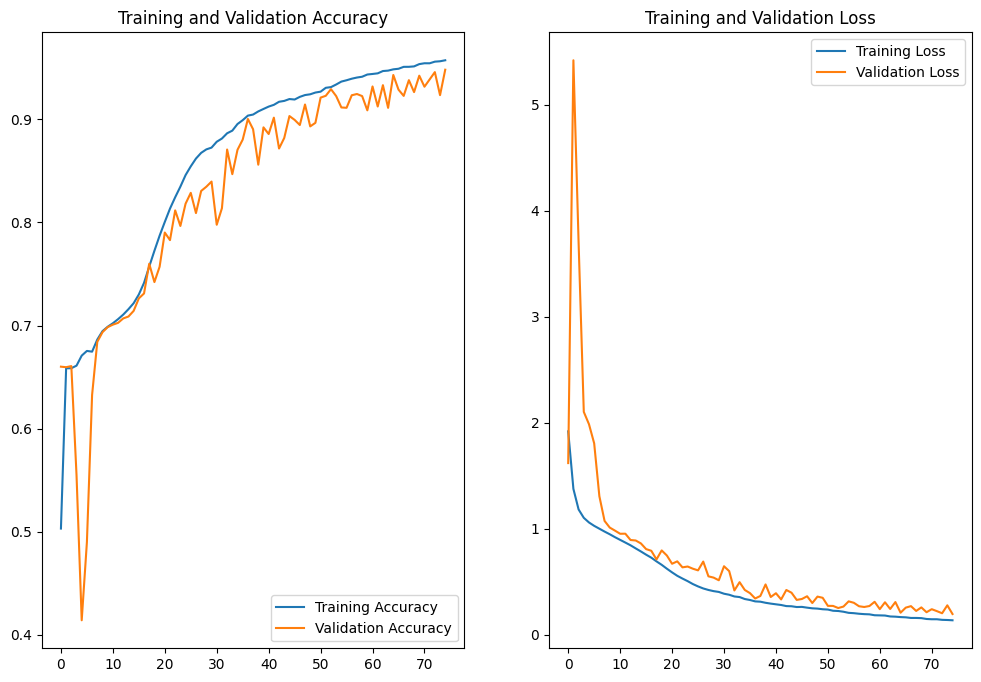

In [4]:
history = segmentation_model.train(train_images, train_masks, val_images, val_masks)
segmentation_model.plot_training(history)


In [5]:
val_predictions = segmentation_model.model.predict(pred_images)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


[[[[2.20560580e-01 3.00842579e-02 2.48082265e-01 ... 2.07635239e-02
    1.81483895e-01 1.12072676e-02]
   [4.02036369e-01 1.00423940e-01 3.56077105e-02 ... 6.18198328e-02
    1.49614692e-01 1.87052542e-03]
   [6.29450738e-01 6.20936695e-03 6.33128583e-02 ... 2.01309957e-02
    7.52203763e-02 1.28544844e-03]
   ...
   [7.84923375e-01 6.47200877e-03 1.65192597e-02 ... 2.32189242e-02
    2.54135765e-02 8.14525876e-04]
   [7.50409424e-01 1.61543116e-03 1.63362864e-02 ... 1.47750704e-02
    3.37466411e-03 3.45780718e-04]
   [2.76866466e-01 1.52075691e-02 1.31065696e-01 ... 4.61735912e-02
    1.04688764e-01 1.63550470e-02]]

  [[4.07479167e-01 1.95734333e-02 5.74810132e-02 ... 2.37796456e-02
    1.28535450e-01 1.30609442e-02]
   [6.66925788e-01 2.10504197e-02 2.59238426e-02 ... 1.17297685e-02
    3.21188159e-02 5.31669590e-04]
   [7.71987259e-01 2.65387679e-03 2.47806013e-02 ... 4.38612374e-03
    2.29711328e-02 5.86080248e-04]
   ...
   [9.26878273e-01 6.87013962e-04 2.21793028e-03 ... 3.21

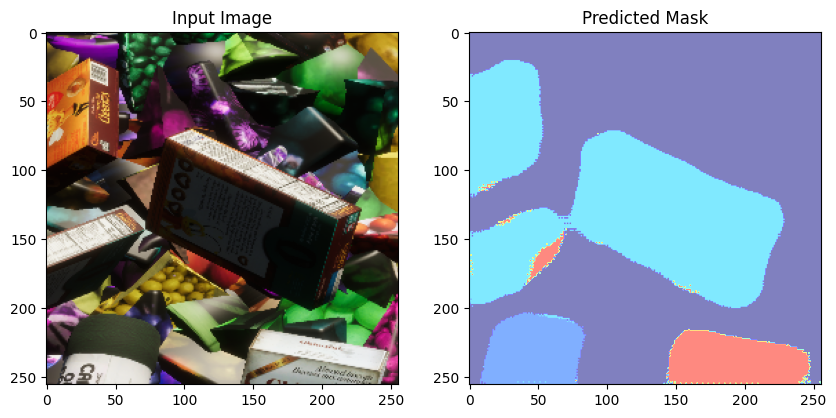

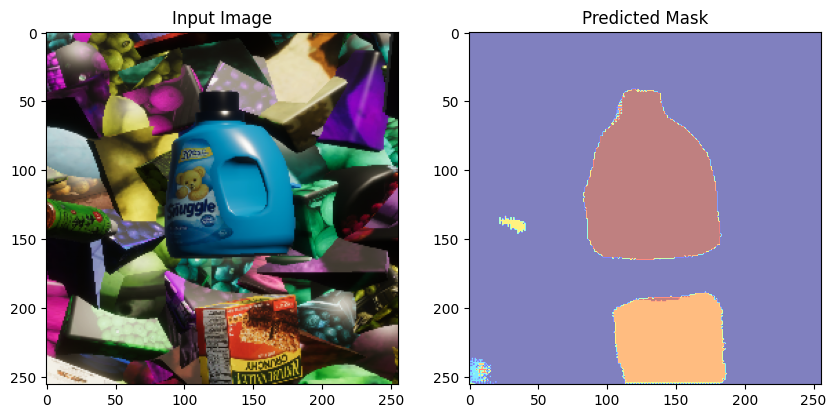

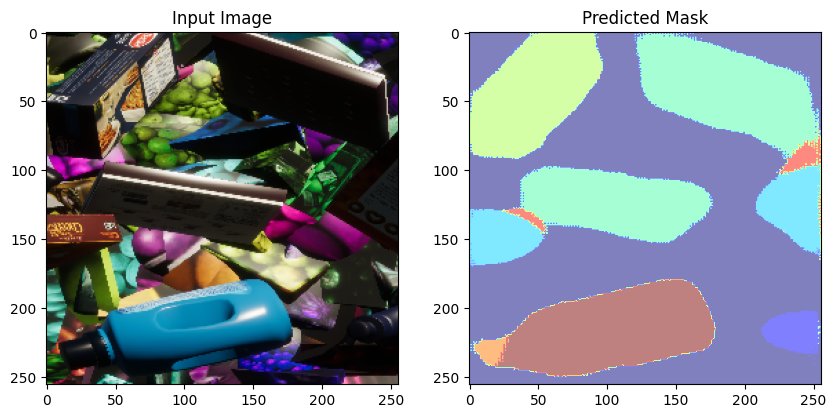

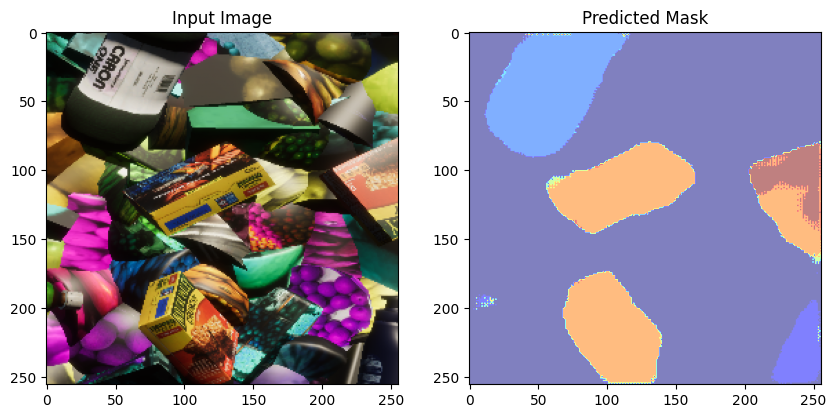

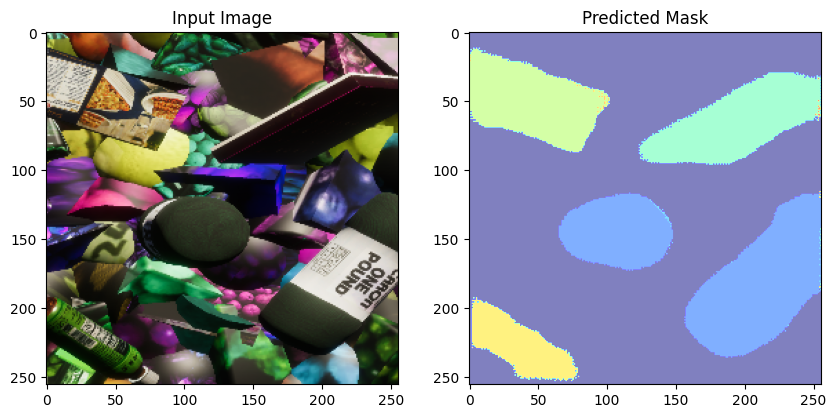

In [8]:
print(val_predictions)

for i in range(5):
    segmentation_model.visualize_prediction(pred_images[i], val_predictions[i])